In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/transport_data.csv')
df.head()

,log,lat,request_ts,trans_ts,label
0,30.295780,59.932167,1511956827,1511956594,0
1,30.219528,59.954617,1511956827,1511956746,-
2,30.409101,59.931679,1511956827,1511956747,-
3,30.293602,59.938892,1511956827,1511956759,-
4,30.360102,59.931103,1511956827,1511956767,-


In [3]:
min_t = df['trans_ts'].min()

df['trans_ts'] = df['trans_ts'] - min_t
df['request_ts'] = df['request_ts'] - min_t

df['day'] = df['trans_ts'] // 86400
df['local_trans_ts'] = df['trans_ts'] % 86400

df.tail()

,log,lat,request_ts,trans_ts,label,day,local_trans_ts
58660,30.382755,59.942825,345771,345766,?,4,166
58661,30.306246,59.943558,345801,345782,-,4,182
58662,30.306704,59.933582,345801,345783,0,4,183
58663,30.373922,59.937569,345801,345787,-,4,187
58664,30.336237,59.934052,345801,345795,-,4,195


In [4]:
df_clean = df[df['label'] != '-']

df_train = df_clean[df_clean['label'] != '?']
df_dev = df_clean[df_clean['label'] == '?']

df_train['label'] = pd.to_numeric(df_train['label'])
df_train.head()

/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,log,lat,request_ts,trans_ts,label,day,local_trans_ts
0,30.295780,59.932167,233,0,0,0,0
8,30.385973,59.944260,233,188,0,0,188
13,30.374880,59.938213,233,208,1,0,208
17,30.347544,59.932667,233,217,0,0,217
23,30.312321,59.937405,233,226,2,0,226


/media/andre6o6/aux/anaconda3/envs/nn/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


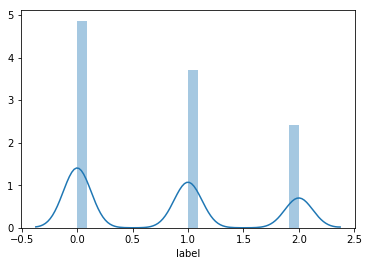

In [5]:
sns.distplot(df_train['label'])

In [6]:
_='''df_d1 = df_train[df_train['day'] == 0]
t = df_d1['request_ts'].unique()
n = len(t)

from matplotlib import animation

fig = plt.figure(figsize=(8, 8))
ax = plt.axes(xlim=(59.91, 59.98), ylim=(30.20, 30.50))
ax.set_autoscalex_on(False)
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    plt.cla()
    sp0 = ax.scatter(df_d1['lat'].values, df_d1['log'].values, alpha=0.5, c='grey', s=1)
    
    df_t = df_d1[df_d1['request_ts'] == t[i]]
    df_t0 = df_d1[df_d1['request_ts'] == t[i-1]]
    #df_t0 = df_t0[df_t0['request_ts'] > t[ min(0, i-2) ]]
    
    sp1 = ax.scatter(df_t0['lat'].values, df_t0['log'].values, alpha=0.3, c=df_t0['label'].values)
    sp2 = ax.scatter(df_t['lat'].values, df_t['log'].values, c=df_t['label'].values)
    return sp0, sp1, sp2

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=10, blit=False)

anim.save('map.mp4', fps=10, extra_args=['-vcodec', 'libx264'])
plt.show()'''

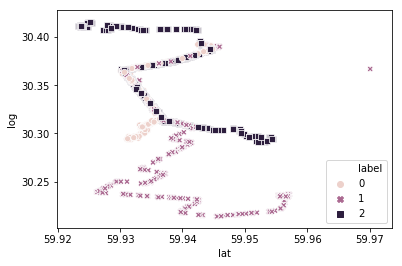

In [7]:
sns.scatterplot(x='lat', y='log', data=df_train, hue="label", style="label")

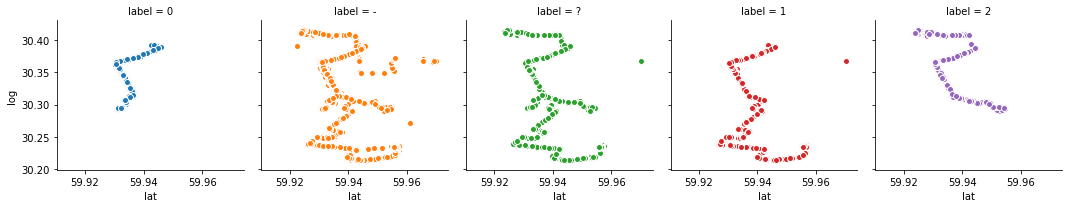

In [8]:
g = sns.FacetGrid(df, col="label", hue="label")
g = (g.map(plt.scatter, "lat", "log", edgecolor="w"))

In [9]:
y = df_train["label"].values
X = df_train.drop(columns="label").values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

(8000, 6) (2000, 6)
8000 2000


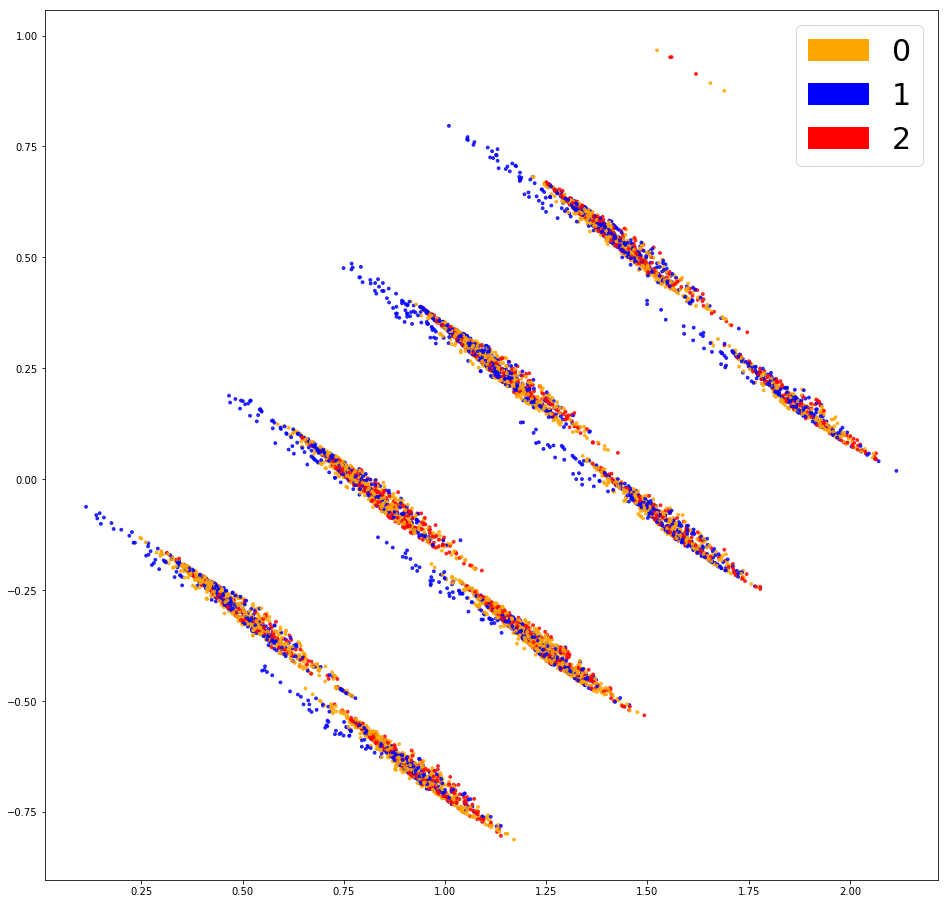

In [12]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='0')
            green_patch = mpatches.Patch(color='blue', label='1')
            teal_patch = mpatches.Patch(color='red', label='2')
            plt.legend(handles=[red_patch, green_patch, teal_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train, y_train)
plt.show()